In [1]:
import numpy as np
import ray

from q1physrl import analyse, train, phys
import matplotlib.pyplot as plt

/home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
ray.init()

2016-02-11 16:43:24,033	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2016-02-11 16:43:24,035	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2016-02-11 16:43:24,115	INFO resource_spec.py:212 -- Starting Ray with 3.81 GiB memory available for workers and up to 1.91 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2016-02-11 16:43:24,385	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2016-02-11 16:43:24,436	WARNING services.py:1004 -- Failed to start the reporter. The reporter requires 'pip install psutil'.


{'node_ip_address': '10.120.1.181',
 'redis_address': '10.120.1.181:10708',
 'object_store_address': '/tmp/ray/session_2016-02-11_16-43-24_035504_4516/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2016-02-11_16-43-24_035504_4516/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2016-02-11_16-43-24_035504_4516'}

In [3]:
trainer = train.make_trainer()

2016-02-11 16:43:24,676	INFO trainer.py:377 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2016-02-11 16:43:24,695	ERROR logger.py:328 -- pip install 'ray[tune]' to see TensorBoard files.
2016-02-11 16:43:24,699	WARNING logger.py:417 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2016-02-11 16:43:24,707	INFO trainer.py:524 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=4558) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=4558)   warnings.warn(msg)
(pid=4558) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=4558)   warnings.warn(msg)
(pid=4559) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
(pid=4559)   warnings.warn(msg)
(pid=4559) /home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. You

2016-02-11 16:43:33,369	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2016-02-11 16:43:33,370	WARNING util.py:44 -- Install psutil to monitor system performance.


In [4]:
FNAME = '../checkpoints/checkpoint-7867'
trainer.restore(FNAME)

2016-02-11 16:43:33,527	WARNING trainable.py:210 -- Getting current IP.
2016-02-11 16:43:33,529	INFO trainable.py:416 -- Restored on 10.120.1.181 from checkpoint: ../checkpoints/checkpoint-7867
2016-02-11 16:43:33,530	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 7867, '_timesteps_total': 31468000, '_time_total': 18382.96403336525, '_episodes_total': 87900}


In [5]:
r = analyse.eval_sim(trainer)

/home/matt/100m-rl/q1physrl/phys.py:89: RuntimeWarning: invalid value encountered in true_divide
  return np.where((speed > 0)[:, None], h_vel * (new_speed / speed)[:, None], h_vel)
/home/matt/100m-rl/q1physrl/phys.py:99: RuntimeWarning: invalid value encountered in true_divide
  wish_vel / unclipped_wish_speed[:, None],
/home/matt/100m-rl/q1physrl/phys.py:104: RuntimeWarning: invalid value encountered in true_divide
  (wish_speed / unclipped_wish_speed),


Plot relative angle with a backing image showing the delta v that would be attained if the relative angle were there

In [6]:
delta_speeds = []

move_angle = 180. * np.arctan2(r.player_state.vel[:, 1], r.player_state.vel[:, 0]) / np.pi

for rel_wish_angle in np.arange(-180, 180):
    inputs = phys.Inputs(
        yaw=move_angle + rel_wish_angle,
        pitch=np.zeros_like(move_angle),
        roll=np.zeros_like(move_angle),
        fmove=np.full_like(move_angle, 800.),
        smove=np.zeros_like(move_angle),
        button2=r.player_state.vel[:, 2] <= 16,
        time_delta=np.full_like(move_angle, 0.014),
    )
    speed_before = np.linalg.norm(r.player_state.vel[:, :2], axis=1)
    next_player_state = phys.apply(inputs, r.player_state)
    speed_after = np.linalg.norm(next_player_state.vel[:, :2], axis=1)
    
    delta_speeds.append(speed_after - speed_before)
    
delta_speeds = np.stack(delta_speeds)

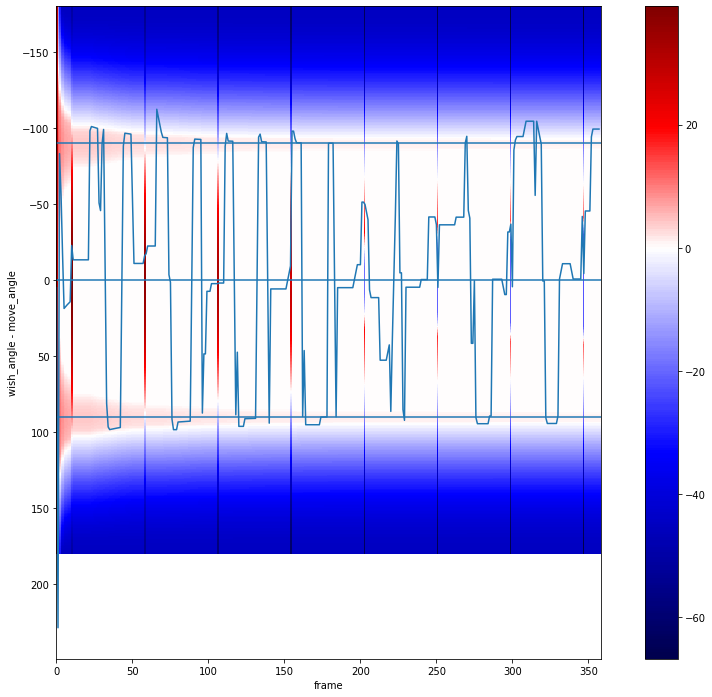

In [94]:
from matplotlib import colors

wish_angle = r.yaw + (180. * np.arctan2(r.smove, r.fmove) / np.pi)

vmin = np.min(delta_speeds)
vmax = np.max(delta_speeds)
norm = colors.DivergingNorm(vmin=vmin, vcenter=0., vmax=vmax)

plt.figure(figsize=(16, 12))
plt.ylabel('wish_angle - move_angle')
plt.xlabel('frame')
plt.imshow(delta_speeds, cmap='seismic', norm=norm,
           extent=(0, delta_speeds.shape[1], 180, -180)
          )
plt.plot(wish_angle - move_angle)
plt.axhline(0)
plt.axhline(90)
plt.axhline(-90)

plt.colorbar()
plt.show()

Plot max attainable delta-v against obtained delta-v

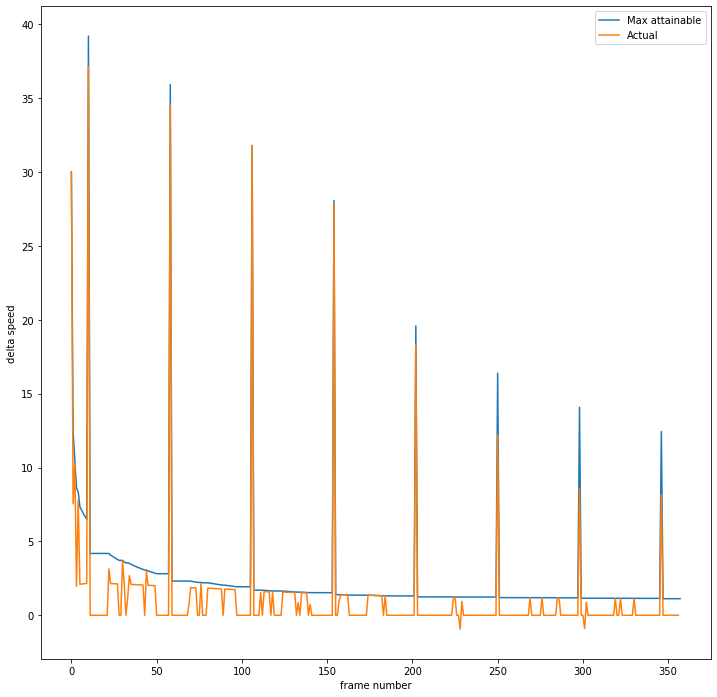

In [65]:
plt.figure(figsize=(12, 12))
plt.xlabel('frame number')
plt.ylabel('delta speed')
plt.plot(np.max(delta_speeds, axis=0), label='Max attainable')
plt.plot(np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1)), label='Actual')
plt.legend()

Per-frame attainable delta speed given relative angle, with actual angle, delta speed plotted

In [151]:
FRAME_NUM = 105

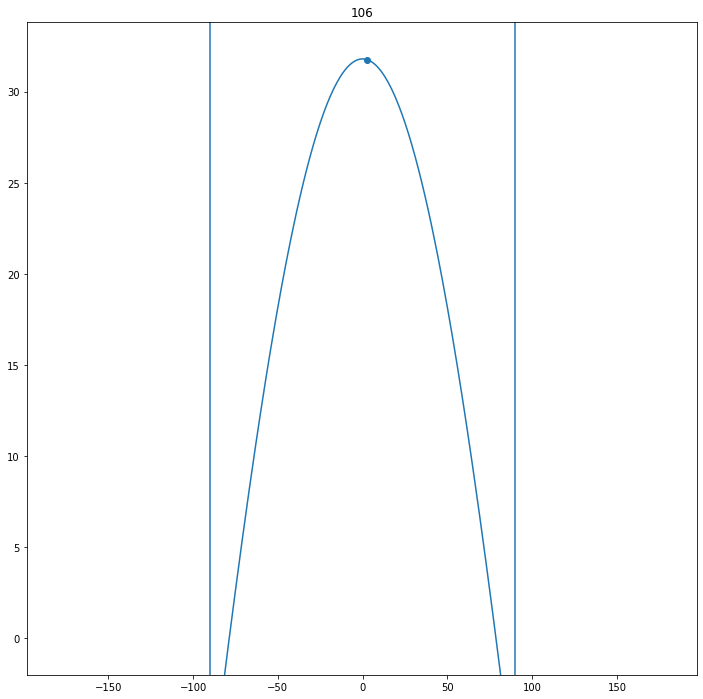

In [152]:
FRAME_NUM += 1

plt.figure(figsize=(12, 12))
plt.title(FRAME_NUM)
plt.ylim(-2, np.max(delta_speeds[:, FRAME_NUM]) + 2)
plt.axvline(-90)
plt.axvline(90)
plt.plot(np.arange(-180, 180), delta_speeds[:, FRAME_NUM])

plt.scatter((wish_angle - move_angle)[FRAME_NUM],
            np.diff(np.linalg.norm(r.player_state.vel[:, :2], axis=1))[FRAME_NUM])

In [ ]:
#Blank space to avoid scrolling when the above image redraws











































